In [1]:
import os
from pathlib import Path
compe='chaii-hindi-and-tamil-question-answering'
is_kaggle=os.environ.get('KAGGLE_KERNEL_RUNTYPE','')
if is_kaggle:
    path=Path(f'../input/{compe}')
    ! pip install -Uqq fastai
else:
    import kaggle,zipfile
    path=Path(f'{compe}')
    if not path.exists():
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{compe}.zip').extractall(path)

In [2]:
!cd chaii-hindi-and-tamil-question-answering;ls

sample_submission.csv test.csv              train.csv


In [3]:
from fastai.tabular.all import *
from sklearn.metrics import roc_auc_score

pd.options.display.float_format = '{:.2f}'.format
set_seed(42)

In [58]:
df=pd.read_csv(f'{compe}/train.csv')
df_test=pd.read_csv(f'{compe}/test.csv')
df_sub=pd.read_csv(f'{compe}/sample_submission.csv')

len(df),len(df_test)

(1114, 5)

In [59]:
df.head(2)

,id,context,question,answer_text,answer_start,language
0,903deec17,"ஒரு சாதாரண வளர்ந்த மனிதனுடைய எலும்புக்கூடு பின்வரும் 206 (மார்பெலும்பு மூன்று பகுதிகளாகக் கருதப்பட்டால் 208) எண்ணிக்கையான எலும்புகளைக் கொண்டிருக்கும். இந்த எண்ணிக்கை உடற்கூட்டியல் வேறுபாடுகளைப் பொறுத்து மாறுபடக்கூடும். எடுத்துக்காட்டாக, மிகக் குறைந்த எண்ணிக்கையான மனிதர்களில், ஒரு மேலதிக விலா எலும்பு (கழுத்துவில்) அல்லது ஒரு மேலதிகமான கீழ் முதுகெலும்பு காணப்படுவதுண்டு; இணைந்த சில எலும்புகளைத் தனி எலும்பாகக் கருதாவிடின், ஐந்து இணைந்த திருவெலும்பு; மூன்று (3 - 5) குயிலலகு எலும்புகள் சேர்ந்து 26 எண்ணிக்கையிலான முதுகெலும்புகள் 33 ஆகக் கருதப்படலாம்.\nமனித மண்டையோட்டில் 22 எலும்புகள் (காதுச் சிற்...",மனித உடலில் எத்தனை எலும்புகள் உள்ளன?,206,53,tamil
1,d9841668c,"காளிதாசன் (தேவநாகரி: कालिदास) சமஸ்கிருத இலக்கியத்தில் சிறந்து விளங்கிய இந்தியக் கவிஞர், நாடகாசிரியர். காளிதாசரைப் பற்றிய முழுமையான வரலாற்றுக்குறிப்புகள் அறியப்படவில்லை.[1] ஆயினும், இவரது படைப்புகளான சாகுந்தலம், மேகதூதம், இரகுவம்சம், குமாரசம்பவம், மாளவிகாக்கினிமித்திரம், விக்கிரமோர்வசியம், ருது சம்ஹாரம் ஆகியவை இந்திய மொழி இலக்கியங்களில் முக்கிய இடம் வகிக்கிறது. இவர் குப்தரகளின் காலத்தில் வாழ்ந்த ஐந்தாம் நூற்றாண்டைச் சேர்ந்தவர் என்று கருதப்படுகிறது.[2][3] இவரின் காவியங்கள் இயற்கை அழகை வருணிப்பதாகவும், அக்காலத்தே வாழ்ந்த மக்களின் பண்பாட்டை பிரதிபலிப்பதாகவும் அமைந்துள்ளது.\n காலம் \nகாளிதாசன்;...",காளிதாசன் எங்கு பிறந்தார்?,காசுமீரில்,2358,tamil


In [60]:
df_test.head(2)

,id,context,question,language
0,22bff3dec,"ज्वाला गुट्टा (जन्म: 7 सितंबर 1983; वर्धा, महाराष्ट्र) एक भारतीय बैडमिंटन खिलाडी हैं। \n प्रारंभिक जीवन \nज्वाला गुट्टा का जन्म 7 सितंबर 1983 को वर्धा, महाराष्ट्र में हुआ था। उनके पिता एम. क्रांति तेलुगु और मां येलन चीन से हैं। उनकी मां येलन गुट्टा पहली बार 1977 में अपने दादा जी के साथ भारत आई थीं। ज्वाला गुट्टा की प्रारंभिक पढ़ाई हैदराबाद से हुई और यहीं से उन्होंने बैडमिंटन खेलना भी शुरू किया। \n कॅरियर \n10 साल की उम्र से ही ज्वाला गुट्टा ने एस.एम. आरिफ से ट्रेनिंग लेना शुरू कर दिया था। एस.एम. आरिफ भारत के जाने माने खेल प्रशिक्षक हैं जिन्हें द्रोणाचार्य अवार्ड से सम्मानित किया गया है। पह...",ज्वाला गुट्टा की माँ का नाम क्या है,hindi
1,282758170,"गूगल मानचित्र (Google Maps) (पूर्व में गूगल लोकल) गूगल द्वारा निःशुल्क रूप से प्रदत्त (गैर-व्यावसायिक उपयोग के लिए) एक वेब मैपिंग सर्विस एप्लिकेशन और तकनीक है जिसके द्वारा गूगल मानचित्र वेबसाइट, गूगल राइड फाइंडर, गूगल ट्रांजिट[1] और गूगल मानचित्र एपीआई के माध्यम से तीसरे पक्ष की वेबसाइटों में सन्निहित मानचित्रों सहित कई मानचित्र-आधारित सेवाएं संचालित होती हैं।[2] यह दुनिया भर के अनेकों देशों के लिए सड़कों के नक़्शे उपलब्ध कराता है जो पैदल, कार या सार्वजनिक वाहन से यात्रा करने वालों और शहर में व्यवसायों की खोज करने वालों के लिए मार्ग योजनाकार का काम करता है। गूगल मानचित्र के उपग्रह से लिए ग...",गूगल मैप्स कब लॉन्च किया गया था?,hindi


In [61]:
df_sub.head(2)

,id,PredictionString
0,22bff3dec,NaN
1,282758170,NaN


In [8]:
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, pipeline

model_name = "deepset/xlm-roberta-large-squad2"

# a) Get predictions
nlp = pipeline('question-answering', model=model_name, tokenizer=model_name)
QA_input = {
    'question': 'Why is model conversion important?',
    'context': 'The option to convert models between FARM and transformers gives freedom to the user and let people easily switch between frameworks.'
}
res = nlp(QA_input)

In [10]:
# b) Load model & tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [9]:
print(res)

{'score': 0.3094027042388916, 'start': 58, 'end': 133, 'answer': ' gives freedom to the user and let people easily switch between frameworks.'}


In [31]:
QA_input = {
    'question': 'காளிதாசன் எங்கு பிறந்தார் ?',
    'context': 'காளிதாசன் (தேவநாகரி: कालिदास) சமஸ்கிருத இலக்கியத்தில் சிறந்து விளங்கிய இந்தியக் கவிஞர், நாடகாசிரியர். காளிதாசரைப் பற்றிய முழுமையான வரலாற்றுக்குறிப்புகள் அறியப்படவில்லை.[1] ஆயினும், இவரது படைப்புகளான சாகுந்தலம், மேகதூதம், இரகுவம்சம், குமாரசம்பவம், மாளவிகாக்கினிமித்திரம், விக்கிரமோர்வசியம், ருது சம்ஹாரம் ஆகியவை இந்திய மொழி இலக்கியங்களில் முக்கிய இடம் வகிக்கிறது. இவர் குப்தரகளின் காலத்தில் வாழ்ந்த ஐந்தாம் நூற்றாண்டைச் சேர்ந்தவர் என்று கருதப்படுகிறது.[2][3] இவரின் காவியங்கள் இயற்கை அழகை வருணிப்பதாகவும், அக்காலத்தே வாழ்ந்த மக்களின் பண்பாட்டை பிரதிபலிப்பதாகவும் அமைந்துள்ளது.\n காலம் \nகாளிதாசன்'
}
res = nlp(QA_input)
print(res)

{'score': 0.0012853497173637152, 'start': 397, 'end': 457, 'answer': ' ஐந்தாம் நூற்றாண்டைச் சேர்ந்தவர் என்று கருதப்படுகிறது.[2][3]'}


In [62]:
df['num_tokens_context']=df['context'].apply(lambda x: len(tokenizer(x)['input_ids']))

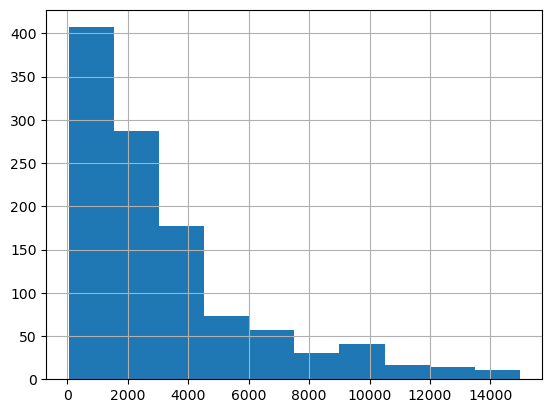

In [63]:
df['num_tokens_context'].hist()
plt.show()

In [64]:
def convert_answers(r):
    start=r[0]
    text=r[1]
    return {
        'answer_start':[start],
        'text':[text]
    }

In [65]:
df=df.sample(frac=1,random_state=42)
df['answers']=df[['answer_start','answer_text']].apply(convert_answers,axis=1)
df.head(2)

,id,context,question,answer_text,answer_start,language,num_tokens_context,answers
879,cd1339bdd,"एरीजोना (English: Arizona) संयुक्त राज्य अमेरिका के दक्षिणपश्चिमी हिस्से में स्थित राज्य है। इसका सबसे बड़ा शहर और राजधानी फ़िनक्स है। दूसरा सबसे बड़ा राज्य टक्सन है और उसके बाद फ़िनक्स के महानगर क्षेत्र स्थित शहर मेसा, ग्लेनडेल, चंदलर और स्कोत्ट्सडेल है।\nएरीजोना संयुक्त राज्यों में शामिल होने वाला ४८व राज्य था जिसे की इसमें १४ फरबरी १९१२ को समिलित किया गया। इसी दिन इस राज्य की देश में माने जाने वाली भूमि की वर्षागाठ भी थी। एरीजोना अपने रेगिस्तानी मौसम, भयंकर गर्मी और हल्की ठंड के लिए जाना जाता है। पर राज्य के उच्च इलाकों में बहुत पहाड़ व जंगल है, इसी कारण वहाँ का मौसम अन्य राज्य के मुकाब...",एरिज़ोना की राजधानी क्या है?,फ़िनक्स,123,hindi,300,"{'answer_start': [123], 'text': ['फ़िनक्स']}"
101,4c38392a6,"ஆத்திரேலியா, ஆஸ்திரேலியா அல்லது அவுஸ்திரேலியா (Australia) என்பது உலகின் மிகச்சிறிய கண்டமாகவும் உலகின் மிகப்பெரும் தீவாகவும் உள்ள பெருநிலப்பரப்பையும், தாஸ்மானியா தீவு, இந்திய, பசிபிக் பெருங்கடல்களில் உள்ள சில சிறிய தீவுகளையும் உள்ளடக்கிய நாடு. இது பொதுநலவாய ஆஸ்திரேலியா (Commonwealth of Australia) என அதிகாரபூர்வமாக அழைக்கப்படுகிறது. எந்த நாட்டுடனும் இதற்கு நில எல்லை கிடையாது. இந்தோனீசியா, கிழக்குத் திமோர், பப்புவா நியூ கினி ஆகிய நாடுகள் இதன் வடக்கேயும், சொலமன் தீவுகள், வனுவாட்டு, நியூ கலிடோனியா ஆகியன வடகிழக்கேயும், நியூசிலாந்து தென்கிழக்கேயும் இதன் அயல் நாடுகளாக அமைந்துள்ளன.\nகிட்டத்தட்ட 42,...",அவுஸ்திரேலியா நாட்டின் தலைநகரம் எது?,கான்பரா,1472,tamil,7227,"{'answer_start': [1472], 'text': ['கான்பரா']}"


In [66]:
df_train=df[:-64].reset_index(drop=True)
df_valid=df[-64:].reset_index(drop=True)

In [67]:
from datasets import Dataset

In [75]:
train_dataset=Dataset.from_pandas(df_train)
valid_dataset=Dataset.from_pandas(df_valid)

train_dataset.features

{'id': Value(dtype='string', id=None),
 'context': Value(dtype='string', id=None),
 'question': Value(dtype='string', id=None),
 'answer_text': Value(dtype='string', id=None),
 'answer_start': Value(dtype='int64', id=None),
 'language': Value(dtype='string', id=None),
 'num_tokens_context': Value(dtype='int64', id=None),
 'answers': {'answer_start': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
  'text': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}}

In [69]:
pad_on_right = tokenizer.padding_side == "right"

In [70]:
def prepare_train_features(ex):
    ex['question']=[q.lstrip() for q in ex['question']]
    tokenized_examples = tokenizer(
        ex["question" if pad_on_right else "context"],
        ex["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=384,
        stride=128,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    offset_mapping = tokenized_examples.pop("offset_mapping")
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []
    
    for i, offsets in enumerate(offset_mapping):
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)
        sequence_ids = tokenized_examples.sequence_ids(i)
        sample_index = sample_mapping[i]
        answers = ex["answers"][sample_index]
        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            # Start token index of the current span in the text.
            token_start_index = 0
            while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
                token_start_index += 1

            # End token index of the current span in the text.
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
                token_end_index -= 1

            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

In [71]:
tokenized_train_ds = train_dataset.map(
    prepare_train_features, batched=True, remove_columns=train_dataset.column_names)

Map:   0%|          | 0/1050 [00:00<?, ? examples/s]

In [73]:
tokenized_train_ds[0]

{'input_ids': [0,
  9489,
  18992,
  18600,
  2284,
  1748,
  471,
  48886,
  6004,
  460,
  32,
  2,
  2,
  9489,
  4010,
  44186,
  1748,
  15,
  135832,
  12,
  157487,
  16,
  44269,
  10665,
  24701,
  287,
  33717,
  220294,
  659,
  225799,
  421,
  44294,
  10665,
  460,
  125,
  61205,
  13353,
  30061,
  22770,
  871,
  48886,
  41612,
  15356,
  16338,
  460,
  125,
  171172,
  13353,
  30061,
  10665,
  19315,
  16338,
  998,
  460,
  871,
  30237,
  6435,
  41612,
  15356,
  16338,
  287,
  122519,
  10386,
  44294,
  22770,
  9163,
  6125,
  4,
  183625,
  12031,
  179151,
  4,
  6,
  170915,
  69168,
  871,
  6,
  28979,
  141747,
  53617,
  179151,
  460,
  125,
  9489,
  4010,
  44186,
  1748,
  44269,
  175167,
  421,
  51560,
  12509,
  44257,
  6,
  132504,
  1964,
  10665,
  3813,
  103667,
  471,
  64133,
  38205,
  6,
  55603,
  3277,
  4010,
  16875,
  86142,
  629,
  2218,
  115869,
  3282,
  4029,
  5349,
  125,
  64021,
  3927,
  2534,
  10665,
  471,
  6143,

In [76]:
tokenized_valid_ds = valid_dataset.map(
    prepare_train_features, batched=True, remove_columns=train_dataset.column_names)

Map:   0%|          | 0/64 [00:00<?, ? examples/s]

In [77]:
train_dataset.column_names

['id',
 'context',
 'question',
 'answer_text',
 'answer_start',
 'language',
 'num_tokens_context',
 'answers']

In [78]:
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer

model = AutoModelForQuestionAnswering.from_pretrained(model_name)

In [84]:
? Trainer

In [80]:
batch_size=4

In [81]:
args = TrainingArguments(
     f"chaii-qa",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=3e-5,
    warmup_ratio=0.1,
    gradient_accumulation_steps=8,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=1,
    weight_decay=0.01,
)

In [83]:
from transformers import default_data_collator
data_collator=default_data_collator

In [87]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_train_ds,
    eval_dataset=tokenized_valid_ds,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
